In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns 

In [58]:
def plot_results(df, model_name):
    """
    Given a dataframe with results of the model, plot accuracy and loss of epochs 
    
    """
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(15, 5)
    fig.suptitle(model_name)
    df.plot(y=['train acc', 'val acc'], ax=axes[0])
    axes[0].set_title('Accuracy')
    axes[1].set_title('Loss')
    best_train_acc = df['train acc'].max()
    best_train_acc_epoch = df['train acc'].idxmax(0)
    best_test_acc = df['val acc'].max()
    best_test_acc_epoch = df['val acc'].idxmax(0)
    best_train_loss = df['train loss'].min()
    best_train_loss_epoch = df['train loss'].idxmin(0)
    best_test_loss = df['val loss'].min()
    best_test_loss_epoch = df['val loss'].idxmin(0)
    axes[0].set_xlabel('Best train acc: {:.2f} on epoch {}\nBest test acc: {:.2f} on epoch {}'
                       .format(best_train_acc, best_train_acc_epoch, best_test_acc, best_test_acc_epoch))
    axes[1].set_xlabel('Best train loss: {:.2f} on epoch {}\nBest test loss: {:.2f} on epoch {}'
                   .format(best_train_loss, best_train_loss_epoch, best_test_loss, best_test_loss_epoch))
    df.plot(y=['train loss', 'val loss'], ax=axes[1])

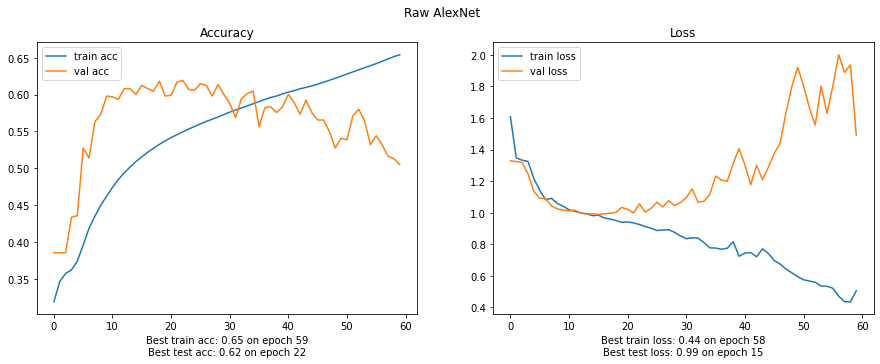

In [59]:
df = pd.read_csv('first_result.csv', delimiter=';')
df = df.head(60)
plot_results(df, 'Raw AlexNet')

In [28]:
df = pd.read_csv('results.csv', delimiter=';')

In [29]:
emotion_results = df.loc[df['task']=='emotion']
emotion_results = emotion_results.drop('task', axis=1)
emotion_results

,result,subset,metric,epoch
0,0.400896,train,accuracy,1
1,0.420913,train,accuracy,2
2,0.431224,train,accuracy,3
3,0.451218,train,accuracy,4
4,0.467357,train,accuracy,5
...,...,...,...,...
395,0.030812,test,loss,96
396,0.021270,test,loss,97
397,0.032410,test,loss,98
398,0.035414,test,loss,99


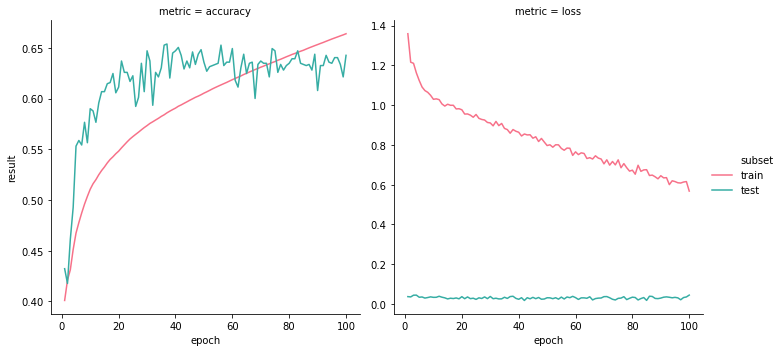

In [61]:
sns.relplot(x='epoch', y='result', hue='subset', size=None, style=None, 
            data=emotion_results, col='metric', palette='husl',
            kind='line', height=5, aspect=1, 
            facet_kws={
                'sharey': False
            })

In [44]:
accuracies = df.loc[df['metric']=='accuracy']

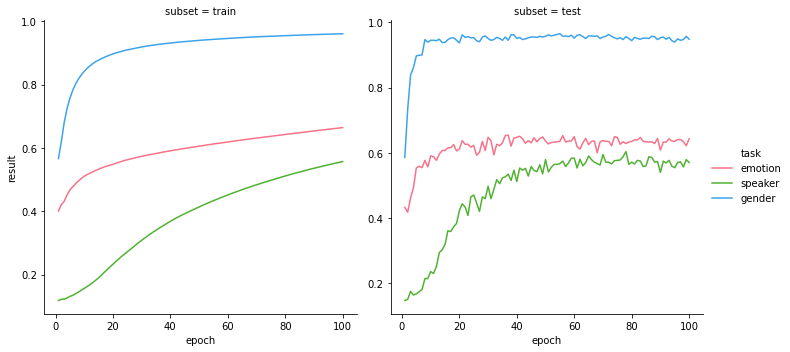

In [56]:
plot = sns.relplot(x='epoch', y='result', hue='task', size=None, style=None, 
            data=accuracies, col='subset', palette='husl',
            kind='line', height=5, aspect=1, 
            facet_kws={
                'sharey': False
            })

In [71]:
accuracies.loc[(accuracies['subset'] == 'test') & (accuracies['task'] == 'emotion')]['result'].max()

0.6539753639417694